<a href="https://colab.research.google.com/github/Vj-Ydv/Suicidal_sentiment_analysis/blob/main/Sentiment140_Analysis_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This cell connects to google drive, authenticates connection, and iterates over file list displaying each file's title and ID.
# it also imports and installs all the necessary libraries
!pip install -U -q PyDrive
!pip install -U -q wordcloud
!pip install -U -q bokeh
!pip install textblob
!pip install sklearn

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from bs4 import BeautifulSoup

from wordcloud import WordCloud
from scipy.stats import hmean
from scipy.stats import norm
from pylab import *
from bokeh.plotting import figure
from bokeh.io import output_notebook, show
from bokeh.models import LinearColorMapper
from bokeh.models import HoverTool

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

from time import time

  

     |████████████████████████████████| 366 kB 5.6 MB/s 
     |████████████████████████████████| 18.5 MB 496 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
panel 0.12.1 requires bokeh<2.4.0,>=2.3.0, but you have bokeh 2.4.2 which is incompatible.


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
%cd /content/drive/My Drive/Colab Notebooks/

/content/drive/My Drive/Colab Notebooks


In [ ]:

cols = ['sentiment','id','date','query_string','user','text']
df_train = pd.read_csv('training.1600000.processed.noemoticon.csv',header=None, usecols = [0,5],names=cols, encoding='latin-1')
clean_tweets = []   
# drop rows with neutral sentiment 
df_train.drop(df_train[df_train.sentiment == 2].index, inplace=True)
# drop rows with retweet text 
df_train.drop(df_train[df_train.text.str.contains(' RT ')].index, inplace=True)

df_train

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,4,Just woke up. Having no school is the best fee...
1599996,4,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,Happy 38th Birthday to my boo of alll time!!! ...


In [ ]:
#Strips emojis
def handle_emojis(tweet):
    # Smile -- :), : ), :-), (:, ( :, (-:, :'),:D, : D, =)
    tweet = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\))|:\s?D | =\)', '', tweet)
    # Sad -- :-(, : (, :(, ):, )-: , :p
    tweet = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:)|:p', '', tweet)
    return tweet
  

In [ ]:
#clean data
url = re.compile(r"(?:(http[s]?://\S+)|((//)?(\w+\.)?\w+\.\w+/\S+))")
user_mention = re.compile(r"(?:(?<!\w)@\w+\b)")
number = re.compile(r"(?:\b\d+\b)")
repeated_char = '([a-zA-Z])\\1+'
length_repeated_char = '\\1\\1'

def clean(raw):
  #convert HTML encoding to text
  new_row = BeautifulSoup(raw, 'html.parser').get_text()
  
  #Change all text to lower case
  new_row = new_row.lower()
  
  #Replaces any url with class URL
  new_row = re.sub(url, '', new_row)
  
  #replace any @username with class USERNAME
  new_row = re.sub(user_mention, '', new_row)
  
  #Strips repeated chars
  new_row = re.sub(repeated_char, length_repeated_char, new_row)
  
  #Replaces #hashtag with hashtag
  new_row = re.sub(r'#(\S+)', r' \1 ', new_row)
  
  #Remove numbers
  new_row = re.sub(number, '', new_row)
  
  #decode text with 'utf-8-sig'
  try:
    temp_row = new_row.decode("utf-8-sig").replace(u"\ufffd", "?")     
  except:
    temp_row = new_row
  
  #Removes emojis
  new_row = handle_emojis(temp_row);
  
  return new_row

In [ ]:
#data preprocessing
chunks_range = [0,400000,800000,1200000,1600000] 
for i in range(chunks_range[3],chunks_range[4]):   #repeat for all range i.e. 0-1, 1-2, 2-3, 3-4
  clean_tweets.append(clean(df_train['text'][i]))
  


In [ ]:
len(clean_tweets)

1600000

In [ ]:
#save to csv file
clean_df = pd.DataFrame(clean_tweets, columns=['text'])
clean_df['target'] = df_train.sentiment

clean_df.to_csv('Dataset_For_Project/clean_Tweets_sentiment140.csv',encoding='utf-8')


In [ ]:

# upload file into pandas dataframe and drop unnecessary columns and neutral rows

# Using columns 1,2 because col 0 is the number of the row, could be changed if the row number is removed from the csv file.
df_clean = pd.read_csv('Dataset_For_Project/clean_Tweets_sentiment140.csv', usecols = [1,2], encoding='latin-1')

df_clean

,text,target
0,"- aww, that's a bummer. you shoulda got dav...",0
1,is upset that he can't update his facebook by ...,0
2,i dived many times for the ball. managed to s...,0
3,my whole body feels itchy and like its on fire,0
4,"no, it's not behaving at all. i'm mad. why am...",0
...,...,...
1599995,just woke up. having no school is the best fee...,4
1599996,thewdb.com - very cool to hear old walt interv...,4
1599997,are you ready for your mojo makeover? ask me f...,4
1599998,happy 38th birthday to my boo of all time!!! t...,4


In [ ]:
# Checking read cleaned file info if there are any null entries (found none) or white space
df_clean.info()
df_clean['text'] = df_clean['text'].str.strip()
df_clean.drop(df_clean[df_clean.text == ''].index, inplace=True)
df_clean

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   text    1600000 non-null  object
 1   target  1600000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


,text,target
0,"- aww, that's a bummer. you shoulda got david...",0
1,is upset that he can't update his facebook by ...,0
2,i dived many times for the ball. managed to sa...,0
3,my whole body feels itchy and like its on fire,0
4,"no, it's not behaving at all. i'm mad. why am ...",0
...,...,...
1599995,just woke up. having no school is the best fee...,4
1599996,thewdb.com - very cool to hear old walt interv...,4
1599997,are you ready for your mojo makeover? ask me f...,4
1599998,happy 38th birthday to my boo of all time!!! t...,4


In [ ]:
df_clean.shape

(1597176, 2)

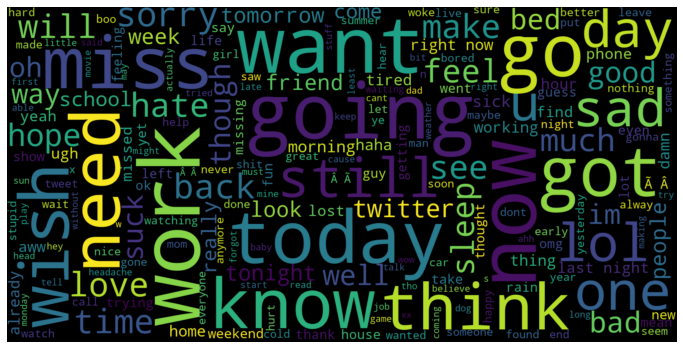

In [ ]:
# Visualizing negative tweets in a word cloud format
neg_tweets = df_clean[df_clean.target == 0]
neg_string = []
for t in neg_tweets.text:
    neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep=' ')

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(neg_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()



In [ ]:
# Observing some of the negative tweets that contain the word "love"
for t in neg_tweets.text[:200]:
    if 'love' in t:
        print (t)

ahh ive always wanted to see rent  love the soundtrack!!
meh... almost lover is the exception... this track gets me depressed every time.
awe i love you too!!!!  am here  i miss you
damn! the grind is inspirational and saddening at the same time.  don't want you to stop cuz i like what u do! much love
i'm missing you babe..  but as long as your alive i'm happy.. yawwnn.. i'm tired my love imma try to sleep hopefully you had a headstart
love the french. i tell people here in the south i'm qtr. french and they snarl at me.  french are beautiful people


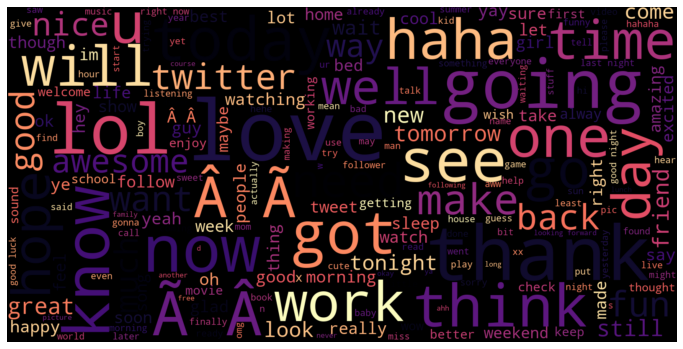

In [ ]:
# Visualizing positive tweets in a word cloud format
pos_tweets = df_clean[df_clean.target == 4]
pos_string = []
for t in pos_tweets.text:
    pos_string.append(t)
    
pos_string = pd.Series(pos_string).str.cat(sep=' ')

wordcloud = WordCloud(width=1600, height=800,max_font_size=200,colormap='magma').generate(pos_string)
plt.figure(figsize=(12,10)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off") 
plt.show()

In [ ]:
# Using CountVectorizer library to analyze frequency of words in tweets
cvec = CountVectorizer()
cvec.fit(df_clean.text)

len(cvec.get_feature_names()) # outputs total number of words


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


263017

In [ ]:
# Building term frequency table to observe the most frequent words in the dataset, notice that all of them are stop words.
neg_doc_matrix = cvec.transform(df_clean[df_clean.target == 0].text)
pos_doc_matrix = cvec.transform(df_clean[df_clean.target == 4].text)
neg_tf = np.sum(neg_doc_matrix,axis=0)
pos_tf = np.sum(pos_doc_matrix,axis=0)
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))
term_freq_df = pd.DataFrame([neg,pos],columns=cvec.get_feature_names()).transpose()
term_freq_df.head()

term_freq_df.columns = ['negative', 'positive']
term_freq_df['total'] = term_freq_df['negative'] + term_freq_df['positive']
term_freq_df.sort_values(by='total', ascending=False).iloc[:10]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,negative,positive,total
to,313132,252526,565658
the,257833,265966,523799
my,190836,125964,316800
it,157204,147496,304700
and,153965,149629,303594
you,103841,198187,302028
is,128016,108919,236935
in,115433,101080,216513
for,98982,117361,216343
of,92716,91082,183798


Text(0.5, 1.0, 'Top 500 tokens in tweets')

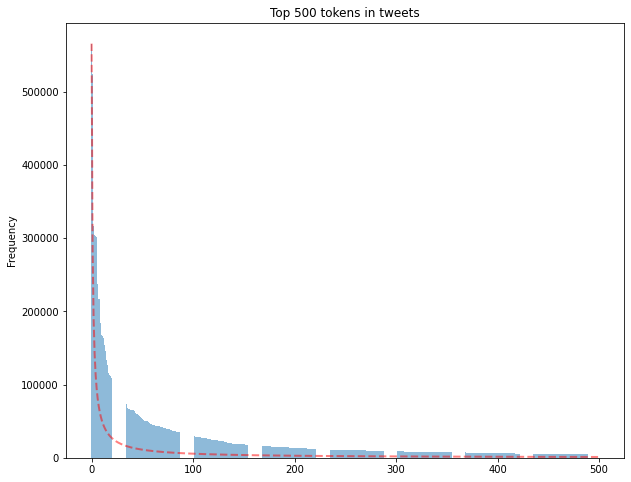

In [ ]:
# Plotting tokens' frequency to see if they follow zipf's law( which states that the frequecy of the rth word => f(r) is directly prop with 1 / r)
y_pos = np.arange(500)
plt.figure(figsize=(10,8))
s = 1
expected_zipf = [term_freq_df.sort_values(by='total', ascending=False)['total'][0]/(i+1)**s for i in y_pos]
plt.bar(y_pos, term_freq_df.sort_values(by='total', ascending=False)['total'][:500], align='center', alpha=0.5)
plt.plot(y_pos, expected_zipf, color='r', linestyle='--',linewidth=2,alpha=0.5)
plt.ylabel('Frequency')
plt.title('Top 500 tokens in tweets')

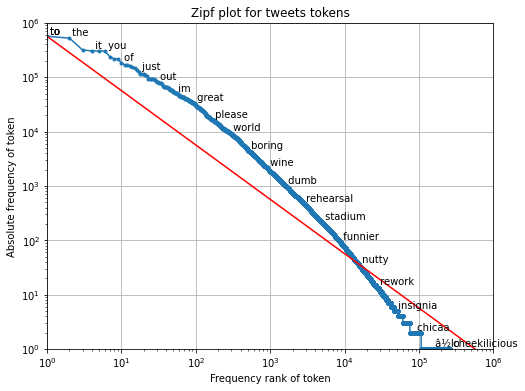

In [ ]:
# Using a log-log graph, like the last one, near zipfian should be a straight line, we notice in more frequent words, their freq is above expected zipfian, and less freuent is below near zipfian
counts = term_freq_df.total
tokens = term_freq_df.index
ranks = arange(1, len(counts)+1)
indices = argsort(-counts)
frequencies = counts[indices]
plt.figure(figsize=(8,6))
plt.ylim(1,10**6)
plt.xlim(1,10**6)
loglog(ranks, frequencies, marker=".")
plt.plot([1,frequencies[0]],[frequencies[0],1],color='r')
title("Zipf plot for tweets tokens")
xlabel("Frequency rank of token")
ylabel("Absolute frequency of token")
grid(True)
for n in list(logspace(-0.5, log10(len(counts)-2), 25).astype(int)):
    dummy = text(ranks[n], frequencies[n], " " + tokens[indices[n]], 
                 verticalalignment="bottom",
                 horizontalalignment="left")

In [ ]:
# Now we want to see what are the most frequent words in positive and negative tweets seperately.
cvec = CountVectorizer(stop_words='english',max_features=10000) # Removing stop words this time and limiting studied words to 10k
cvec.fit(df_clean.text)
document_matrix = cvec.transform(df_clean.text)


In [ ]:
df_clean[df_clean.target == 4]

,text,target
800000,i love u guys r the best!!,4
800001,im meeting up with one of my besties tonight! ...,4
800002,"thanks for the twitter add, sunisa! i got to m...",4
800003,being sick can be really cheap when it hurts t...,4
800004,he has that effect on everyone,4
...,...,...
1599995,just woke up. having no school is the best fee...,4
1599996,thewdb.com - very cool to hear old walt interv...,4
1599997,are you ready for your mojo makeover? ask me f...,4
1599998,happy 38th birthday to my boo of all time!!! t...,4


In [ ]:
# Processing negative tweets
%%time
neg_batches = np.linspace(0,798491,10).astype(int)
i=0
neg_tf = []
while i < len(neg_batches)-1:
    batch_result = np.sum(document_matrix[neg_batches[i]:neg_batches[i+1]].toarray(),axis=0)
    neg_tf.append(batch_result)
    print (neg_batches[i+1],"entries' term freuquency calculated")
    i += 1

88721 entries' term freuquency calculated
177442 entries' term freuquency calculated
266163 entries' term freuquency calculated
354884 entries' term freuquency calculated
443606 entries' term freuquency calculated
532327 entries' term freuquency calculated
621048 entries' term freuquency calculated
709769 entries' term freuquency calculated
798491 entries' term freuquency calculated
CPU times: user 18.5 s, sys: 21.1 s, total: 39.6 s
Wall time: 39.8 s


In [ ]:
# Processing positive tweets
%%time
pos_batches = np.linspace(800000,1599999,10).astype(int)
i=0
pos_tf = []
while i < len(pos_batches)-1:
    batch_result = np.sum(document_matrix[pos_batches[i]:pos_batches[i+1]].toarray(),axis=0)
    pos_tf.append(batch_result)
    print (pos_batches[i+1],"entries' term freuquency calculated")
    i += 1

888888 entries' term freuquency calculated
977777 entries' term freuquency calculated
1066666 entries' term freuquency calculated
1155555 entries' term freuquency calculated
1244443 entries' term freuquency calculated
1333332 entries' term freuquency calculated
1422221 entries' term freuquency calculated
1511110 entries' term freuquency calculated
1599999 entries' term freuquency calculated
CPU times: user 21.2 s, sys: 5.54 s, total: 26.8 s
Wall time: 26.6 s


In [ ]:
# Displaying the top frequent words(non-stop) in both positive and negative tweets
neg = np.sum(neg_tf,axis=0)
pos = np.sum(pos_tf,axis=0)
term_freq_df2 = pd.DataFrame([neg,pos],columns=cvec.get_feature_names()).transpose()
term_freq_df2.columns = ['negative', 'positive']
term_freq_df2['total'] = term_freq_df2['negative'] + term_freq_df2['positive']
term_freq_df2.sort_values(by='total', ascending=False).iloc[:10]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,negative,positive,total
just,64013,62803,126816
good,29554,63259,92813
day,39856,47119,86975
like,41046,37451,78497
today,38114,30043,68157
work,45402,19481,64883
love,16989,47598,64587
going,33684,30873,64557
got,33288,27955,61243
lol,23136,36062,59198


Text(0.5, 1.0, 'Top 50 tokens in negative tweets')

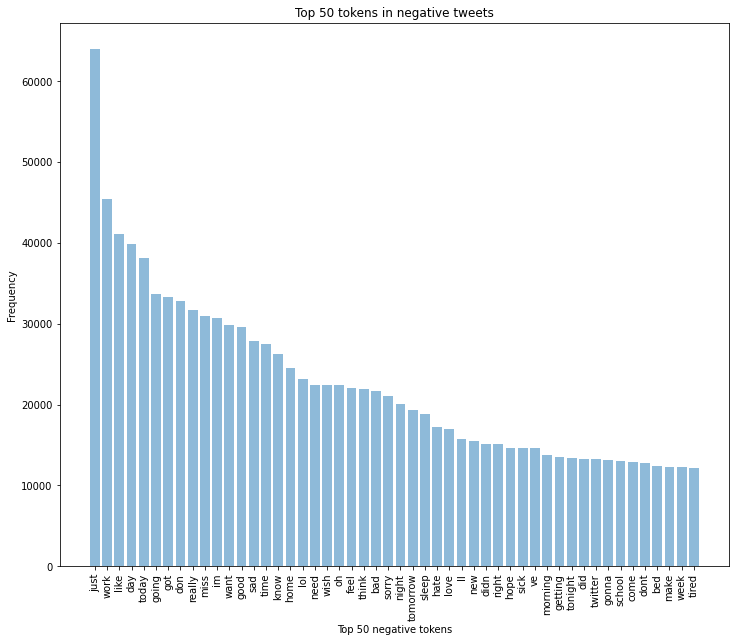

In [ ]:
# Displaying most common words in negative tweets
y_pos = np.arange(50)
plt.figure(figsize=(12,10))
plt.bar(y_pos, term_freq_df2.sort_values(by='negative', ascending=False)['negative'][:50], align='center', alpha=0.5)
plt.xticks(y_pos, term_freq_df2.sort_values(by='negative', ascending=False)['negative'][:50].index,rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 50 negative tokens')
plt.title('Top 50 tokens in negative tweets')



Text(0.5, 1.0, 'Top 50 tokens in positive tweets')

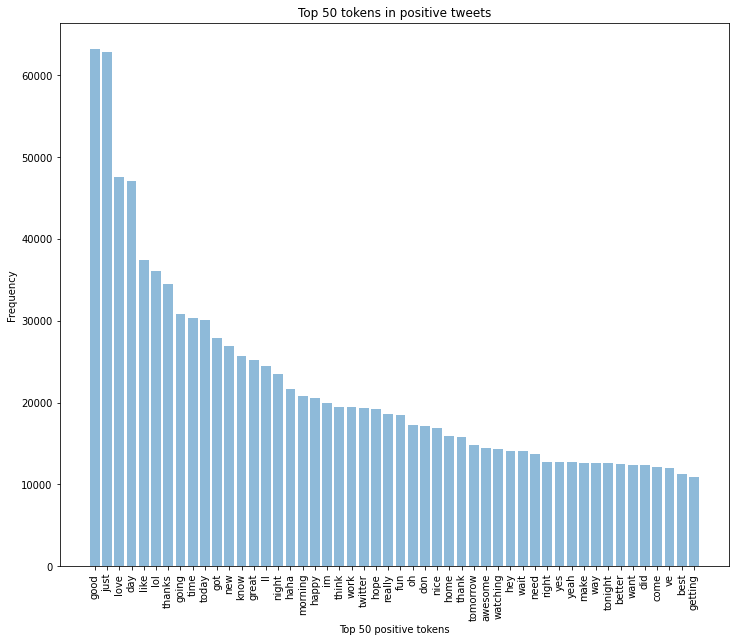

In [ ]:
# Displaying most common words in positive tweets
y_pos = np.arange(50)
plt.figure(figsize=(12,10))
plt.bar(y_pos, term_freq_df2.sort_values(by='positive', ascending=False)['positive'][:50], align='center', alpha=0.5)
plt.xticks(y_pos, term_freq_df2.sort_values(by='positive', ascending=False)['positive'][:50].index,rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 50 positive tokens')
plt.title('Top 50 tokens in positive tweets')

Text(0.5, 1.0, 'Negative Frequency vs Positive Frequency')

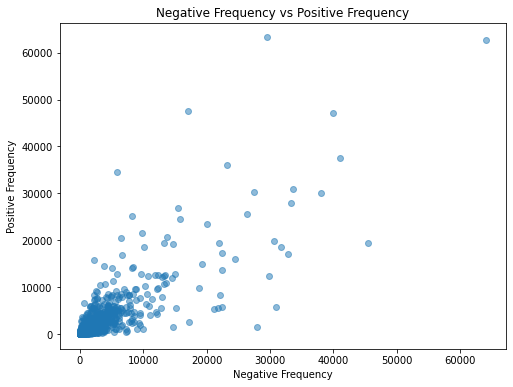

In [ ]:
# We noticed in the above many neutral words occuring in both classes, let's plot the negative frequency of a word on X-axis, and the positive frequency on Y-axis
plt.figure(figsize=(8,6))
ax = sns.regplot(x="negative", y="positive",fit_reg=False, scatter_kws={'alpha':0.5},data=term_freq_df2)
plt.ylabel('Positive Frequency')
plt.xlabel('Negative Frequency')
plt.title('Negative Frequency vs Positive Frequency')

In [ ]:
# As we can't infer much meaning from the previous plots, let's define a pos_rate and neg_rate, to indicate the rate of freq of a word in a certain class vs the other class
term_freq_df2['pos_rate'] = term_freq_df2['positive'] * 1./term_freq_df2['total']
term_freq_df2.sort_values(by='pos_rate', ascending=False).iloc[:10]

,negative,positive,total,pos_rate
mileymonday,0,161,161,1.000000
dividends,0,83,83,1.000000
m2e,0,79,79,1.000000
tweeterfollow,0,654,654,1.000000
iamsoannoyed,0,246,246,1.000000
emailunlimited,0,100,100,1.000000
tweeteradder,1,830,831,0.998797
shareholder,1,80,81,0.987654
fuzzball,2,99,101,0.980198
recommends,3,109,112,0.973214


In [ ]:
# Now let's define a freq_pct representing the rate by which a word occurs in a certain class only
term_freq_df2['pos_freq_pct'] = term_freq_df2['positive'] * 1./term_freq_df2['positive'].sum()
term_freq_df2.sort_values(by='pos_freq_pct', ascending=False).iloc[:10]

,negative,positive,total,pos_rate,pos_freq_pct
good,29554,63259,92813,0.681575,0.014272
just,64013,62803,126816,0.495229,0.014169
love,16989,47598,64587,0.736959,0.010739
day,39856,47119,86975,0.541753,0.010631
like,41046,37451,78497,0.477101,0.008450
lol,23136,36062,59198,0.609176,0.008136
thanks,5801,34461,40262,0.855919,0.007775
going,33684,30873,64557,0.478229,0.006965
time,27512,30362,57874,0.524622,0.006850
today,38114,30043,68157,0.440791,0.006778


In [ ]:
term_freq_df2['pos_hmean'] = term_freq_df2.apply(lambda x: (hmean([x['pos_rate'], x['pos_freq_pct']]) if x['pos_rate'] > 0 and x['pos_freq_pct'] > 0 else 0), axis=1)               
term_freq_df2.sort_values(by='pos_hmean', ascending=False).iloc[:10]

,negative,positive,total,pos_rate,pos_freq_pct,pos_hmean
good,29554,63259,92813,0.681575,0.014272,0.027959
just,64013,62803,126816,0.495229,0.014169,0.027550
love,16989,47598,64587,0.736959,0.010739,0.021169
day,39856,47119,86975,0.541753,0.010631,0.020852
like,41046,37451,78497,0.477101,0.008450,0.016605
lol,23136,36062,59198,0.609176,0.008136,0.016058
thanks,5801,34461,40262,0.855919,0.007775,0.015410
going,33684,30873,64557,0.478229,0.006965,0.013731
time,27512,30362,57874,0.524622,0.006850,0.013524
today,38114,30043,68157,0.440791,0.006778,0.013351


In [ ]:
from scipy.stats import norm

def normcdf(x):
    return norm.cdf(x, x.mean(), x.std())

term_freq_df2['pos_rate_normcdf'] = normcdf(term_freq_df2['pos_rate'])

term_freq_df2['pos_freq_pct_normcdf'] = normcdf(term_freq_df2['pos_freq_pct'])

term_freq_df2['pos_normcdf_hmean'] = hmean([term_freq_df2['pos_rate_normcdf'], term_freq_df2['pos_freq_pct_normcdf']])

term_freq_df2.sort_values(by='pos_normcdf_hmean',ascending=False).iloc[:10]

,negative,positive,total,pos_rate,pos_freq_pct,pos_hmean,pos_rate_normcdf,pos_freq_pct_normcdf,pos_normcdf_hmean
welcome,620,6690,7310,0.915185,0.001509,0.003014,0.995629,0.999329,0.997476
thank,2291,15796,18087,0.873334,0.003564,0.007099,0.990829,1.000000,0.995394
thanks,5801,34461,40262,0.855919,0.007775,0.015410,0.987746,1.000000,0.993835
awesome,3820,14445,18265,0.790857,0.003259,0.006491,0.967092,1.000000,0.983271
glad,2272,8232,10504,0.783701,0.001857,0.003706,0.963646,0.999968,0.981471
follow,2555,9149,11704,0.781699,0.002064,0.004117,0.962629,0.999996,0.980957
enjoy,1640,5871,7511,0.781654,0.001325,0.002645,0.962606,0.997337,0.979664
sweet,1649,5852,7501,0.780163,0.001320,0.002636,0.961835,0.997255,0.979225
hi,2155,7176,9331,0.769049,0.001619,0.003231,0.955665,0.999726,0.977199
yay,3164,10497,13661,0.768392,0.002368,0.004722,0.955276,1.000000,0.977127


In [ ]:
term_freq_df2['neg_rate'] = term_freq_df2['negative'] * 1./term_freq_df2['total']

term_freq_df2['neg_freq_pct'] = term_freq_df2['negative'] * 1./term_freq_df2['negative'].sum()

term_freq_df2['neg_hmean'] = term_freq_df2.apply(lambda x: (hmean([x['neg_rate'], x['neg_freq_pct']])                                                                if x['neg_rate'] > 0 and x['neg_freq_pct'] > 0                                                                else 0), axis=1)
                                                       
term_freq_df2['neg_rate_normcdf'] = normcdf(term_freq_df2['neg_rate'])

term_freq_df2['neg_freq_pct_normcdf'] = normcdf(term_freq_df2['neg_freq_pct'])

term_freq_df2['neg_normcdf_hmean'] = hmean([term_freq_df2['neg_rate_normcdf'], term_freq_df2['neg_freq_pct_normcdf']])

term_freq_df2.sort_values(by='neg_normcdf_hmean', ascending=False).iloc[:10]

,negative,positive,total,pos_rate,pos_freq_pct,pos_hmean,pos_rate_normcdf,pos_freq_pct_normcdf,pos_normcdf_hmean,neg_rate,neg_freq_pct,neg_hmean,neg_rate_normcdf,neg_freq_pct_normcdf,neg_normcdf_hmean
sad,27917,1507,29424,0.051217,0.000340,0.000676,0.002443,0.707512,0.004869,0.948783,0.005977,0.011880,0.997557,1.000000,0.998777
hurts,7201,454,7655,0.059308,0.000102,0.000205,0.002859,0.502205,0.005686,0.940692,0.001542,0.003079,0.997141,0.999695,0.998417
sick,14616,1414,16030,0.088210,0.000319,0.000636,0.004916,0.690894,0.009763,0.911790,0.003129,0.006237,0.995084,1.000000,0.997536
sucks,9902,981,10883,0.090141,0.000221,0.000442,0.005092,0.608759,0.010100,0.909859,0.002120,0.004230,0.994908,0.999999,0.997447
poor,7480,741,8221,0.090135,0.000167,0.000334,0.005092,0.560750,0.010091,0.909865,0.001602,0.003197,0.994908,0.999821,0.997359
ugh,9049,994,10043,0.098974,0.000224,0.000448,0.005970,0.611320,0.011824,0.901026,0.001937,0.003867,0.994030,0.999994,0.997003
missing,7298,994,8292,0.119875,0.000224,0.000448,0.008600,0.611320,0.016961,0.880125,0.001563,0.003120,0.991400,0.999746,0.995556
headache,5317,420,5737,0.073209,0.000095,0.000189,0.003725,0.495242,0.007394,0.926791,0.001138,0.002274,0.996275,0.993217,0.994744
hate,17206,2609,19815,0.131668,0.000589,0.001172,0.010494,0.866907,0.020736,0.868332,0.003684,0.007337,0.989506,1.000000,0.994725
boo,6178,1047,7225,0.144913,0.000236,0.000472,0.013045,0.621708,0.025554,0.855087,0.001323,0.002641,0.986955,0.998174,0.992533


Text(0.5, 1.0, 'neg_hmean vs pos_hmean')

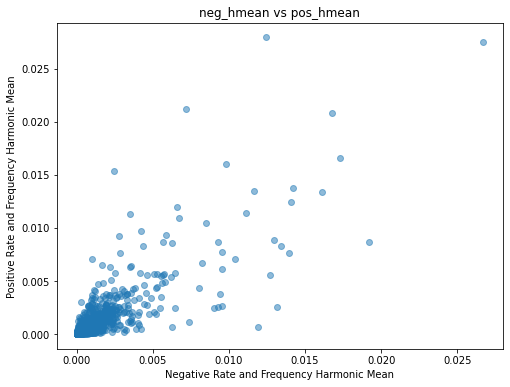

In [ ]:
plt.figure(figsize=(8,6))
ax = sns.regplot(x="neg_hmean", y="pos_hmean",fit_reg=False, scatter_kws={'alpha':0.5},data=term_freq_df2)
plt.ylabel('Positive Rate and Frequency Harmonic Mean')
plt.xlabel('Negative Rate and Frequency Harmonic Mean')
plt.title('neg_hmean vs pos_hmean')

Text(0.5, 1.0, 'neg_normcdf_hmean vs pos_normcdf_hmean')

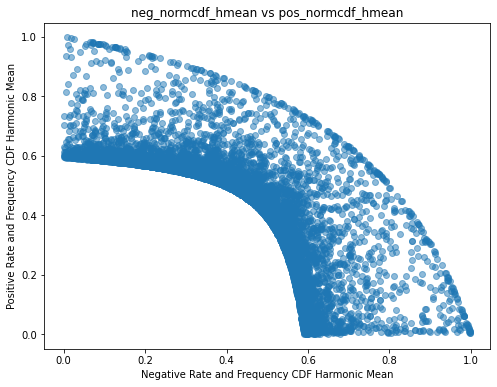

In [ ]:
plt.figure(figsize=(8,6))
ax = sns.regplot(x="neg_normcdf_hmean", y="pos_normcdf_hmean",fit_reg=False, scatter_kws={'alpha':0.5},data=term_freq_df2)
plt.ylabel('Positive Rate and Frequency CDF Harmonic Mean')
plt.xlabel('Negative Rate and Frequency CDF Harmonic Mean')
plt.title('neg_normcdf_hmean vs pos_normcdf_hmean')

In [ ]:
output_notebook()
color_mapper = LinearColorMapper(palette='Inferno256', low=min(term_freq_df2.pos_normcdf_hmean), high=max(term_freq_df2.pos_normcdf_hmean))

p = figure(x_axis_label='neg_normcdf_hmean', y_axis_label='pos_normcdf_hmean')

p.circle('neg_normcdf_hmean','pos_normcdf_hmean',size=5,alpha=0.3,source=term_freq_df2,color={'field': 'pos_normcdf_hmean', 'transform': color_mapper})

hover = HoverTool(tooltips=[('token','@index')])
p.add_tools(hover)
show(p)

In [ ]:
x = df_clean.text
y = df_clean.target

SEED = 2000

#split clean data to two sets : training , validation and test
x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(x, y, test_size=.2, random_state=SEED)
#split the second set into two other sets : validation , test 
x_validation, x_test, y_validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test, test_size=.5, random_state=SEED)


print ("Train set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_train),(len(x_train[y_train == 0]) / (len(x_train)*1.))*100,(len(x_train[y_train == 4]) / (len(x_train)*1.))*100))

print ("Validation set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_validation),(len(x_validation[y_validation == 0]) / (len(x_validation)*1.))*100,(len(x_validation[y_validation == 4]) / (len(x_validation)*1.))*100))

print ("Test set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_test),(len(x_test[y_test == 0]) / (len(x_test)*1.))*100,(len(x_test[y_test == 4]) / (len(x_test)*1.))*100))




Train set has total 1277740 entries with 49.94% negative, 50.06% positive
Validation set has total 159718 entries with 50.31% negative, 49.69% positive
Test set has total 159718 entries with 50.12% negative, 49.88% positive


In [ ]:
print(y_validation)

462454     0
111080     0
927751     4
439155     0
866125     4
          ..
194048     0
1341939    4
128400     0
1367021    4
212981     0
Name: target, Length: 159718, dtype: int64


In [ ]:
# Using Text Blob Python libary for sentiment analysis as baseline for accuracy

tbresult = [TextBlob(i).sentiment.polarity for i in x_validation]
target_names = ['Positive', 'Negative']
tbpred = [0 if n < 0 else 4 for n in tbresult]
conmat = np.array(confusion_matrix(y_validation, tbpred, labels=[4,0]))
confusion = pd.DataFrame(conmat, index=['positive', 'negative'],
                         columns=['predicted_positive','predicted_negative'])

print ("Accuracy Score: {0:.2f}%".format(accuracy_score(y_validation, tbpred)*100))
print ("-"*80)
print ("Confusion Matrix\n")
print (confusion)
print ("-"*80)
# The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. 
# The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

# The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. 
# The recall is intuitively the ability of the classifier to find all the positive samples.

# The F-beta score can be interpreted as a weighted harmonic mean of the precision and recall, 
# where an F-beta score reaches its best value at 1 and worst score at 0.
print ("Classification Report\n")
print (classification_report(y_validation, tbpred,target_names=target_names))

Accuracy Score: 60.86%
--------------------------------------------------------------------------------
Confusion Matrix

          predicted_positive  predicted_negative
positive               71501                7856
negative               54656               25705
--------------------------------------------------------------------------------
Classification Report

              precision    recall  f1-score   support

    Positive       0.77      0.32      0.45     80361
    Negative       0.57      0.90      0.70     79357

    accuracy                           0.61    159718
   macro avg       0.67      0.61      0.57    159718
weighted avg       0.67      0.61      0.57    159718



In [ ]:
def nfeature_accuracy_checker(vectorizer=None, n_features=None, stop_words=None, ngram_range=(1, 1), classifier=None):
    result = []
    print (classifier)
    print ("\n")
    for n in n_features:
        vectorizer.set_params(stop_words=stop_words, max_features=n, ngram_range=ngram_range)
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])
        print ("Validation result for {} features".format(n))
        nfeature_accuracy,tt_time = accuracy_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
        result.append((n,nfeature_accuracy,tt_time))
    return result

In [ ]:
#calculate accuracy for any classifer using {"null accuracy"} and get total time for training and testing
def accuracy_summary(pipeline, x_train, y_train, x_test, y_test):
    if len(x_test[y_test == 0]) / (len(x_test)*1.) > 0.5:
        null_accuracy = len(x_test[y_test == 0]) / (len(x_test)*1.)
    else:
        null_accuracy = 1. - (len(x_test[y_test == 0]) / (len(x_test)*1.))
    t0 = time()
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    train_test_time = time() - t0
    accuracy = accuracy_score(y_test, y_pred)
    print ("null accuracy: {0:.2f}%".format(null_accuracy*100))
    print ("accuracy score: {0:.2f}%".format(accuracy*100))
    if accuracy > null_accuracy:
        print ("model is {0:.2f}% more accurate than null accuracy".format((accuracy-null_accuracy)*100))
    elif accuracy == null_accuracy:
        print ("model has the same accuracy with the null accuracy")
    else:
        print ("model is {0:.2f}% less accurate than null accuracy".format((null_accuracy-accuracy)*100))
    print ("train and test time: {0:.2f}s".format(train_test_time))
    print ("-"*80)
    return accuracy, train_test_time


In [ ]:
# Using count vectorizer to extract features
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from time import time
cvec = CountVectorizer()
lr = LogisticRegression()
n_features = np.arange(10000,100001,10000)


# Unigrams without stop words
print ("RESULT FOR UNIGRAM WITHOUT STOP WORDS\n")
feature_result_wosw = nfeature_accuracy_checker(vectorizer=cvec, n_features=n_features, stop_words='english', classifier=lr)


RESULT FOR UNIGRAM WITHOUT STOP WORDS

LogisticRegression()


Validation result for 10000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.31%
accuracy score: 77.51%
model is 27.19% more accurate than null accuracy
train and test time: 53.31s
--------------------------------------------------------------------------------
Validation result for 20000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.31%
accuracy score: 77.70%
model is 27.39% more accurate than null accuracy
train and test time: 57.56s
--------------------------------------------------------------------------------
Validation result for 30000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.31%
accuracy score: 77.80%
model is 27.48% more accurate than null accuracy
train and test time: 45.08s
--------------------------------------------------------------------------------
Validation result for 40000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.31%
accuracy score: 77.79%
model is 27.48% more accurate than null accuracy
train and test time: 58.55s
--------------------------------------------------------------------------------
Validation result for 50000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.31%
accuracy score: 77.82%
model is 27.51% more accurate than null accuracy
train and test time: 59.69s
--------------------------------------------------------------------------------
Validation result for 60000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.31%
accuracy score: 77.83%
model is 27.51% more accurate than null accuracy
train and test time: 48.49s
--------------------------------------------------------------------------------
Validation result for 70000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.31%
accuracy score: 77.85%
model is 27.54% more accurate than null accuracy
train and test time: 59.98s
--------------------------------------------------------------------------------
Validation result for 80000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.31%
accuracy score: 77.80%
model is 27.48% more accurate than null accuracy
train and test time: 47.70s
--------------------------------------------------------------------------------
Validation result for 90000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.31%
accuracy score: 77.85%
model is 27.54% more accurate than null accuracy
train and test time: 59.73s
--------------------------------------------------------------------------------
Validation result for 100000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.31%
accuracy score: 77.78%
model is 27.47% more accurate than null accuracy
train and test time: 46.33s
--------------------------------------------------------------------------------


In [ ]:
# Unigrams with stop words 
%%time
print ("RESULT FOR UNIGRAM WITH STOP WORDS\n")
feature_result_ug = nfeature_accuracy_checker(vectorizer=cvec, n_features=n_features, classifier=lr)

RESULT FOR UNIGRAM WITH STOP WORDS

LogisticRegression()


Validation result for 10000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.31%
accuracy score: 79.55%
model is 29.24% more accurate than null accuracy
train and test time: 54.84s
--------------------------------------------------------------------------------
Validation result for 20000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.31%
accuracy score: 79.64%
model is 29.33% more accurate than null accuracy
train and test time: 46.74s
--------------------------------------------------------------------------------
Validation result for 30000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.31%
accuracy score: 79.77%
model is 29.45% more accurate than null accuracy
train and test time: 47.06s
--------------------------------------------------------------------------------
Validation result for 40000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.31%
accuracy score: 79.70%
model is 29.39% more accurate than null accuracy
train and test time: 59.96s
--------------------------------------------------------------------------------
Validation result for 50000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.31%
accuracy score: 79.76%
model is 29.45% more accurate than null accuracy
train and test time: 48.97s
--------------------------------------------------------------------------------
Validation result for 60000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.31%
accuracy score: 79.71%
model is 29.40% more accurate than null accuracy
train and test time: 48.56s
--------------------------------------------------------------------------------
Validation result for 70000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.31%
accuracy score: 79.80%
model is 29.48% more accurate than null accuracy
train and test time: 48.92s
--------------------------------------------------------------------------------
Validation result for 80000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.31%
accuracy score: 79.73%
model is 29.42% more accurate than null accuracy
train and test time: 50.81s
--------------------------------------------------------------------------------
Validation result for 90000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.31%
accuracy score: 79.74%
model is 29.43% more accurate than null accuracy
train and test time: 49.66s
--------------------------------------------------------------------------------
Validation result for 100000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.31%
accuracy score: 79.71%
model is 29.40% more accurate than null accuracy
train and test time: 50.49s
--------------------------------------------------------------------------------
CPU times: user 8min 29s, sys: 3min 46s, total: 12min 16s
Wall time: 8min 26s


In [ ]:
# Testing if the custom stop words match the library defined english stop words
from sklearn.feature_extraction import text

a = frozenset(list(term_freq_df.sort_values(by='total', ascending=False).iloc[:10].index))
b = text.ENGLISH_STOP_WORDS
set(a).issubset(set(b))


True

In [ ]:
# Defining custom stop words as top 10 most frequent words in the dataset
my_stop_words = frozenset(list(term_freq_df.sort_values(by='total', ascending=False).iloc[:10].index))

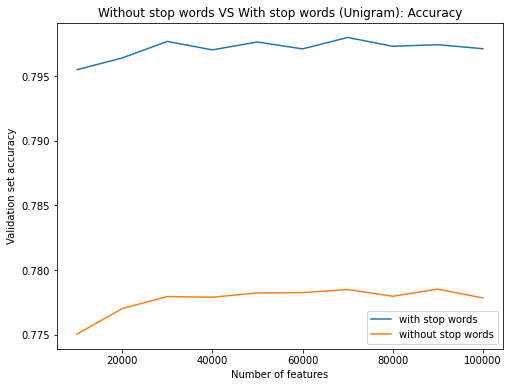

In [ ]:
# Plotting the 2 cases of unigrams against each other (with stop words, without stop words)
nfeatures_plot_ug = pd.DataFrame(feature_result_ug,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ug_wosw = pd.DataFrame(feature_result_wosw,columns=['nfeatures','validation_accuracy','train_test_time'])

plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_ug.nfeatures, nfeatures_plot_ug.validation_accuracy, label='with stop words')
plt.plot(nfeatures_plot_ug_wosw.nfeatures, nfeatures_plot_ug_wosw.validation_accuracy,label='without stop words')
plt.title("Without stop words VS With stop words (Unigram): Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

# NOTE: Results showed that training with stop words produces a better accuracy, so bigrams and trigrams will be processed with stop words

In [ ]:
# Bigrams
print ("RESULT FOR BIGRAM WITH STOP WORDS\n")
feature_result_bg = nfeature_accuracy_checker(vectorizer=cvec, n_features=n_features, ngram_range=(1, 2), classifier=lr)

RESULT FOR BIGRAM WITH STOP WORDS

LogisticRegression()


Validation result for 10000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.31%
accuracy score: 80.52%
model is 30.21% more accurate than null accuracy
train and test time: 85.84s
--------------------------------------------------------------------------------
Validation result for 20000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.31%
accuracy score: 81.23%
model is 30.92% more accurate than null accuracy
train and test time: 90.44s
--------------------------------------------------------------------------------
Validation result for 30000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.31%
accuracy score: 81.44%
model is 31.12% more accurate than null accuracy
train and test time: 90.33s
--------------------------------------------------------------------------------
Validation result for 40000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.31%
accuracy score: 81.49%
model is 31.18% more accurate than null accuracy
train and test time: 91.70s
--------------------------------------------------------------------------------
Validation result for 50000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.31%
accuracy score: 81.59%
model is 31.28% more accurate than null accuracy
train and test time: 91.80s
--------------------------------------------------------------------------------
Validation result for 60000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.31%
accuracy score: 81.64%
model is 31.33% more accurate than null accuracy
train and test time: 94.18s
--------------------------------------------------------------------------------
Validation result for 70000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.31%
accuracy score: 81.68%
model is 31.37% more accurate than null accuracy
train and test time: 95.56s
--------------------------------------------------------------------------------
Validation result for 80000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.31%
accuracy score: 81.70%
model is 31.39% more accurate than null accuracy
train and test time: 95.43s
--------------------------------------------------------------------------------
Validation result for 90000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.31%
accuracy score: 81.69%
model is 31.37% more accurate than null accuracy
train and test time: 95.85s
--------------------------------------------------------------------------------
Validation result for 100000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.31%
accuracy score: 81.69%
model is 31.38% more accurate than null accuracy
train and test time: 96.65s
--------------------------------------------------------------------------------


In [ ]:
# Triagrams
print ("RESULT FOR TRIGRAM WITH STOP WORDS\n")
feature_result_tg = nfeature_accuracy_checker(vectorizer=cvec, n_features=n_features, ngram_range=(1, 3), classifier=lr)


RESULT FOR TRIGRAM WITH STOP WORDS

LogisticRegression()


Validation result for 10000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.31%
accuracy score: 80.42%
model is 30.11% more accurate than null accuracy
train and test time: 155.51s
--------------------------------------------------------------------------------
Validation result for 20000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.31%
accuracy score: 81.17%
model is 30.86% more accurate than null accuracy
train and test time: 160.77s
--------------------------------------------------------------------------------
Validation result for 30000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.31%
accuracy score: 81.48%
model is 31.16% more accurate than null accuracy
train and test time: 164.87s
--------------------------------------------------------------------------------
Validation result for 40000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.31%
accuracy score: 81.62%
model is 31.31% more accurate than null accuracy
train and test time: 160.96s
--------------------------------------------------------------------------------
Validation result for 50000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.31%
accuracy score: 81.72%
model is 31.41% more accurate than null accuracy
train and test time: 165.14s
--------------------------------------------------------------------------------
Validation result for 60000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.31%
accuracy score: 81.72%
model is 31.40% more accurate than null accuracy
train and test time: 162.66s
--------------------------------------------------------------------------------
Validation result for 70000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.31%
accuracy score: 81.81%
model is 31.50% more accurate than null accuracy
train and test time: 167.28s
--------------------------------------------------------------------------------
Validation result for 80000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.31%
accuracy score: 81.82%
model is 31.51% more accurate than null accuracy
train and test time: 165.97s
--------------------------------------------------------------------------------
Validation result for 90000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.31%
accuracy score: 81.85%
model is 31.53% more accurate than null accuracy
train and test time: 170.35s
--------------------------------------------------------------------------------
Validation result for 100000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.31%
accuracy score: 81.84%
model is 31.52% more accurate than null accuracy
train and test time: 170.25s
--------------------------------------------------------------------------------


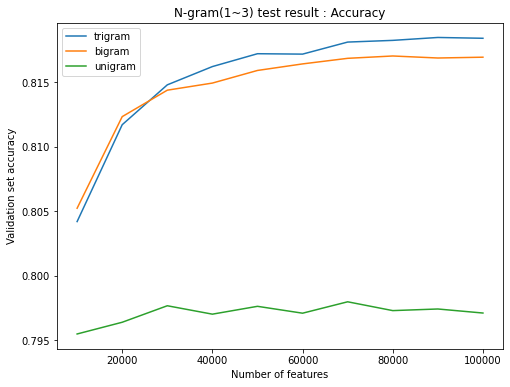

In [ ]:
# Plotting Unigrams Vs Biagrams vs Triagrams on the same graph

nfeatures_plot_tg = pd.DataFrame(feature_result_tg,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_bg = pd.DataFrame(feature_result_bg,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ug = pd.DataFrame(feature_result_ug,columns=['nfeatures','validation_accuracy','train_test_time'])
plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_tg.nfeatures, nfeatures_plot_tg.validation_accuracy,label='trigram')
plt.plot(nfeatures_plot_bg.nfeatures, nfeatures_plot_bg.validation_accuracy,label='bigram')
plt.plot(nfeatures_plot_ug.nfeatures, nfeatures_plot_ug.validation_accuracy, label='unigram')
plt.title("N-gram(1~3) test result : Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()


In [ ]:
#using Tfidf algorithm to extract features
tvec = TfidfVectorizer()
lr = LogisticRegression()
n_features = np.arange(10000,100001,10000)





In [ ]:
#with stopwords in dataset
feature_result_ugt_sw = nfeature_accuracy_checker(vectorizer=tvec, n_features=n_features, classifier=lr)


LogisticRegression()


Validation result for 10000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.31%
accuracy score: 79.71%
model is 29.40% more accurate than null accuracy
train and test time: 44.88s
--------------------------------------------------------------------------------
Validation result for 20000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.31%
accuracy score: 79.86%
model is 29.54% more accurate than null accuracy
train and test time: 49.25s
--------------------------------------------------------------------------------
Validation result for 30000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.31%
accuracy score: 79.96%
model is 29.64% more accurate than null accuracy
train and test time: 49.88s
--------------------------------------------------------------------------------
Validation result for 40000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.31%
accuracy score: 79.97%
model is 29.65% more accurate than null accuracy
train and test time: 50.71s
--------------------------------------------------------------------------------
Validation result for 50000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.31%
accuracy score: 79.97%
model is 29.66% more accurate than null accuracy
train and test time: 51.20s
--------------------------------------------------------------------------------
Validation result for 60000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.31%
accuracy score: 79.92%
model is 29.60% more accurate than null accuracy
train and test time: 51.33s
--------------------------------------------------------------------------------
Validation result for 70000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.31%
accuracy score: 79.96%
model is 29.65% more accurate than null accuracy
train and test time: 54.03s
--------------------------------------------------------------------------------
Validation result for 80000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.31%
accuracy score: 79.96%
model is 29.65% more accurate than null accuracy
train and test time: 53.25s
--------------------------------------------------------------------------------
Validation result for 90000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.31%
accuracy score: 79.96%
model is 29.64% more accurate than null accuracy
train and test time: 53.73s
--------------------------------------------------------------------------------
Validation result for 100000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.31%
accuracy score: 79.98%
model is 29.66% more accurate than null accuracy
train and test time: 54.16s
--------------------------------------------------------------------------------


In [ ]:
#with out stop words in data set
feature_result_ugt_out_sw = nfeature_accuracy_checker(vectorizer=tvec, n_features=n_features, stop_words='english', classifier=lr)


LogisticRegression()


Validation result for 10000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.31%
accuracy score: 77.53%
model is 27.22% more accurate than null accuracy
train and test time: 42.24s
--------------------------------------------------------------------------------
Validation result for 20000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.31%
accuracy score: 77.81%
model is 27.50% more accurate than null accuracy
train and test time: 45.16s
--------------------------------------------------------------------------------
Validation result for 30000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.31%
accuracy score: 77.88%
model is 27.56% more accurate than null accuracy
train and test time: 45.47s
--------------------------------------------------------------------------------
Validation result for 40000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.31%
accuracy score: 77.94%
model is 27.62% more accurate than null accuracy
train and test time: 45.38s
--------------------------------------------------------------------------------
Validation result for 50000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.31%
accuracy score: 77.97%
model is 27.66% more accurate than null accuracy
train and test time: 46.71s
--------------------------------------------------------------------------------
Validation result for 60000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.31%
accuracy score: 78.00%
model is 27.68% more accurate than null accuracy
train and test time: 45.59s
--------------------------------------------------------------------------------
Validation result for 70000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.31%
accuracy score: 77.94%
model is 27.63% more accurate than null accuracy
train and test time: 46.69s
--------------------------------------------------------------------------------
Validation result for 80000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.31%
accuracy score: 77.99%
model is 27.67% more accurate than null accuracy
train and test time: 48.07s
--------------------------------------------------------------------------------
Validation result for 90000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.31%
accuracy score: 77.97%
model is 27.66% more accurate than null accuracy
train and test time: 48.27s
--------------------------------------------------------------------------------
Validation result for 100000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.31%
accuracy score: 78.00%
model is 27.68% more accurate than null accuracy
train and test time: 48.78s
--------------------------------------------------------------------------------


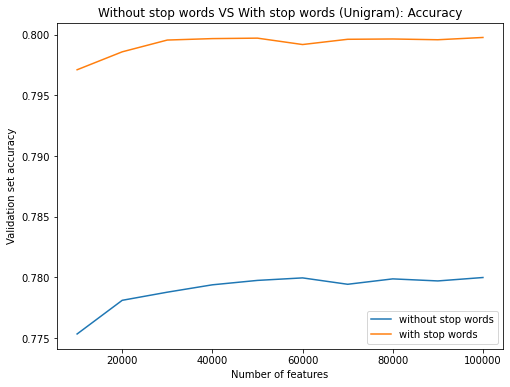

In [ ]:
# unigrams against each other (with stop words, with custom stop words, without stop words) In TfIDF
nfeatures_plot_ugt_out_sw = pd.DataFrame(feature_result_ugt_out_sw,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ugt_sw = pd.DataFrame(feature_result_ugt_sw,columns=['nfeatures','validation_accuracy','train_test_time'])

plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_ugt_out_sw.nfeatures, nfeatures_plot_ugt_out_sw.validation_accuracy, label='without stop words')
plt.plot(nfeatures_plot_ugt_sw.nfeatures, nfeatures_plot_ugt_sw.validation_accuracy,label='with stop words')
plt.title("Without stop words VS With stop words (Unigram): Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

In [ ]:
feature_result_bgt_sw = nfeature_accuracy_checker(vectorizer=tvec,n_features=n_features, ngram_range=(1, 2), classifier=lr)


LogisticRegression()


Validation result for 10000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.31%
accuracy score: 80.64%
model is 30.33% more accurate than null accuracy
train and test time: 85.84s
--------------------------------------------------------------------------------
Validation result for 20000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.31%
accuracy score: 81.35%
model is 31.04% more accurate than null accuracy
train and test time: 91.06s
--------------------------------------------------------------------------------
Validation result for 30000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.31%
accuracy score: 81.67%
model is 31.36% more accurate than null accuracy
train and test time: 93.11s
--------------------------------------------------------------------------------
Validation result for 40000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.31%
accuracy score: 81.81%
model is 31.50% more accurate than null accuracy
train and test time: 93.42s
--------------------------------------------------------------------------------
Validation result for 50000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.31%
accuracy score: 81.89%
model is 31.58% more accurate than null accuracy
train and test time: 95.95s
--------------------------------------------------------------------------------
Validation result for 60000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.31%
accuracy score: 81.95%
model is 31.64% more accurate than null accuracy
train and test time: 97.67s
--------------------------------------------------------------------------------
Validation result for 70000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.31%
accuracy score: 81.98%
model is 31.67% more accurate than null accuracy
train and test time: 99.79s
--------------------------------------------------------------------------------
Validation result for 80000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.31%
accuracy score: 82.03%
model is 31.72% more accurate than null accuracy
train and test time: 99.73s
--------------------------------------------------------------------------------
Validation result for 90000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.31%
accuracy score: 82.05%
model is 31.74% more accurate than null accuracy
train and test time: 100.89s
--------------------------------------------------------------------------------
Validation result for 100000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.31%
accuracy score: 82.07%
model is 31.75% more accurate than null accuracy
train and test time: 102.73s
--------------------------------------------------------------------------------


In [ ]:
feature_result_tgt_sw = nfeature_accuracy_checker(vectorizer=tvec,n_features=n_features, ngram_range=(1, 3), classifier=lr)


LogisticRegression()


Validation result for 10000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.31%
accuracy score: 80.51%
model is 30.20% more accurate than null accuracy
train and test time: 158.12s
--------------------------------------------------------------------------------
Validation result for 20000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.31%
accuracy score: 81.36%
model is 31.05% more accurate than null accuracy
train and test time: 163.49s
--------------------------------------------------------------------------------
Validation result for 30000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.31%
accuracy score: 81.64%
model is 31.33% more accurate than null accuracy
train and test time: 166.48s
--------------------------------------------------------------------------------
Validation result for 40000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.31%
accuracy score: 81.84%
model is 31.53% more accurate than null accuracy
train and test time: 166.44s
--------------------------------------------------------------------------------
Validation result for 50000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.31%
accuracy score: 81.95%
model is 31.63% more accurate than null accuracy
train and test time: 168.63s
--------------------------------------------------------------------------------
Validation result for 60000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.31%
accuracy score: 82.07%
model is 31.75% more accurate than null accuracy
train and test time: 168.79s
--------------------------------------------------------------------------------
Validation result for 70000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.31%
accuracy score: 82.04%
model is 31.73% more accurate than null accuracy
train and test time: 178.04s
--------------------------------------------------------------------------------
Validation result for 80000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.31%
accuracy score: 82.11%
model is 31.80% more accurate than null accuracy
train and test time: 178.39s
--------------------------------------------------------------------------------
Validation result for 90000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.31%
accuracy score: 82.19%
model is 31.88% more accurate than null accuracy
train and test time: 176.83s
--------------------------------------------------------------------------------
Validation result for 100000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.31%
accuracy score: 82.21%
model is 31.90% more accurate than null accuracy
train and test time: 172.81s
--------------------------------------------------------------------------------


In [ ]:
feature_result_tgt_sw_3_3 = nfeature_accuracy_checker(vectorizer=tvec,n_features=n_features, ngram_range=(3, 3), classifier=lr)


LogisticRegression()


Validation result for 10000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.31%
accuracy score: 63.17%
model is 12.85% more accurate than null accuracy
train and test time: 99.92s
--------------------------------------------------------------------------------
Validation result for 20000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.31%
accuracy score: 65.41%
model is 15.09% more accurate than null accuracy
train and test time: 104.72s
--------------------------------------------------------------------------------
Validation result for 30000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.31%
accuracy score: 66.64%
model is 16.32% more accurate than null accuracy
train and test time: 103.83s
--------------------------------------------------------------------------------
Validation result for 40000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.31%
accuracy score: 67.44%
model is 17.12% more accurate than null accuracy
train and test time: 103.98s
--------------------------------------------------------------------------------
Validation result for 50000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.31%
accuracy score: 68.00%
model is 17.68% more accurate than null accuracy
train and test time: 102.27s
--------------------------------------------------------------------------------
Validation result for 60000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.31%
accuracy score: 68.54%
model is 18.22% more accurate than null accuracy
train and test time: 103.88s
--------------------------------------------------------------------------------
Validation result for 70000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.31%
accuracy score: 68.88%
model is 18.56% more accurate than null accuracy
train and test time: 104.35s
--------------------------------------------------------------------------------
Validation result for 80000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.31%
accuracy score: 69.19%
model is 18.88% more accurate than null accuracy
train and test time: 105.83s
--------------------------------------------------------------------------------
Validation result for 90000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.31%
accuracy score: 69.42%
model is 19.10% more accurate than null accuracy
train and test time: 105.16s
--------------------------------------------------------------------------------
Validation result for 100000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.31%
accuracy score: 69.66%
model is 19.35% more accurate than null accuracy
train and test time: 107.41s
--------------------------------------------------------------------------------


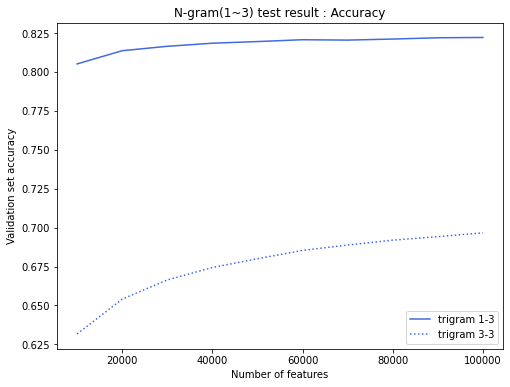

In [ ]:
# Plotting trigram (1,3) features Vs trigram (3,3) features


nfeatures_plot_tgt = pd.DataFrame(feature_result_tgt_sw,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_tgt_3_3 = pd.DataFrame(feature_result_tgt_sw_3_3,columns=['nfeatures','validation_accuracy','train_test_time'])

plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_tgt.nfeatures, nfeatures_plot_tgt.validation_accuracy,label='trigram 1-3',color='royalblue')
plt.plot(nfeatures_plot_tgt_3_3.nfeatures, nfeatures_plot_tgt_3_3.validation_accuracy,label='trigram 3-3',linestyle=':', color='royalblue')
plt.title("N-gram(1~3) test result : Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

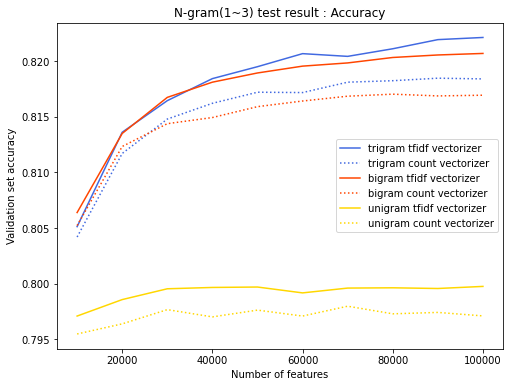

In [ ]:
# Plotting Unigrams Vs Biagrams vs Triagrams on the same graph based on (countvectorizer & tfidf)

nfeatures_plot_tg = pd.DataFrame(feature_result_tg,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_bg = pd.DataFrame(feature_result_bg,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ug = pd.DataFrame(feature_result_ug,columns=['nfeatures','validation_accuracy','train_test_time'])

nfeatures_plot_tgt = pd.DataFrame(feature_result_tgt_sw,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_bgt = pd.DataFrame(feature_result_bgt_sw,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ugt = pd.DataFrame(feature_result_ugt_sw,columns=['nfeatures','validation_accuracy','train_test_time'])

plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_tgt.nfeatures, nfeatures_plot_tgt.validation_accuracy,label='trigram tfidf vectorizer',color='royalblue')
plt.plot(nfeatures_plot_tg.nfeatures, nfeatures_plot_tg.validation_accuracy,label='trigram count vectorizer',linestyle=':', color='royalblue')
plt.plot(nfeatures_plot_bgt.nfeatures, nfeatures_plot_bgt.validation_accuracy,label='bigram tfidf vectorizer',color='orangered')
plt.plot(nfeatures_plot_bg.nfeatures, nfeatures_plot_bg.validation_accuracy,label='bigram count vectorizer',linestyle=':',color='orangered')
plt.plot(nfeatures_plot_ugt.nfeatures, nfeatures_plot_ugt.validation_accuracy, label='unigram tfidf vectorizer',color='gold')
plt.plot(nfeatures_plot_ug.nfeatures, nfeatures_plot_ug.validation_accuracy, label='unigram count vectorizer',linestyle=':',color='gold')
plt.title("N-gram(1~3) test result : Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

In [ ]:
# Trying several classifiers and comparison between them 

from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.neighbors import NearestCentroid
from sklearn.feature_selection import SelectFromModel

names = ["Logistic Regression", "Linear SVC", "LinearSVC with L1-based feature selection","Multinomial NB", 
         "Bernoulli NB", "Ridge Classifier", "AdaBoost", "Perceptron","Passive-Aggresive", "Nearest Centroid"]
classifiers = [
    LogisticRegression(),
    LinearSVC(),
    Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False))),
  ('classification', LinearSVC(penalty="l2"))]),
    MultinomialNB(),
    BernoulliNB(),
    RidgeClassifier(),
    AdaBoostClassifier(),
    Perceptron(),
    PassiveAggressiveClassifier(),
    NearestCentroid()
    ]
zipped_clf = zip(names,classifiers)

tvec = TfidfVectorizer()

#comparator to compare between accuracy of different zipped classifiers

def classifier_comparator(vectorizer=tvec, n_features=None, stop_words=None, ngram_range=None, classifier=zipped_clf):
    result = []
    vectorizer.set_params(stop_words=stop_words, max_features=n_features, ngram_range=ngram_range)
    for n,c in classifier:
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', c)
        ])
        print ("Validation result for {}".format(n))
        print (c)
        clf_accuracy,tt_time = accuracy_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
        result.append((n,clf_accuracy,tt_time))
    return result

trigram_result = classifier_comparator(n_features=100000,ngram_range=(1,3))

Validation result for Logistic Regression
LogisticRegression()


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.31%
accuracy score: 82.21%
model is 31.90% more accurate than null accuracy
train and test time: 173.78s
--------------------------------------------------------------------------------
Validation result for Linear SVC
LinearSVC()
null accuracy: 50.31%
accuracy score: 81.77%
model is 31.46% more accurate than null accuracy
train and test time: 165.52s
--------------------------------------------------------------------------------
Validation result for LinearSVC with L1-based feature selection
Pipeline(steps=[('feature_selection',
                 SelectFromModel(estimator=LinearSVC(dual=False,
                                                     penalty='l1'))),
                ('classification', LinearSVC())])
null accuracy: 50.31%
accuracy score: 81.79%
model is 31.47% more accurate than null accuracy
train and test time: 268.41s
--------------------------------------------------------------------------------
Validation result for Multinomial NB
MultinomialNB()
nul

In [ ]:
#use top 5 of classifiers and use VotingClassifier with voting hard
from sklearn.ensemble import VotingClassifier

clf1 = LogisticRegression()
clf2 = LinearSVC()
clf3 = MultinomialNB()
clf4 = RidgeClassifier()
clf5 = PassiveAggressiveClassifier()

eclf = VotingClassifier(estimators=[('lr', clf1), ('svc', clf2), ('mnb', clf3), ('rcs', clf4), ('pac', clf5)], voting='hard')
checker_pipeline = Pipeline([
              ('vectorizer', TfidfVectorizer(max_features=100000,ngram_range=(1, 3))),
              ('classifier', eclf)
])
print ("Validation result for {}".format('Ensemble'))
print (eclf)
accuracy_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)


Validation result for Ensemble
VotingClassifier(estimators=[('lr', LogisticRegression()), ('svc', LinearSVC()),
                             ('mnb', MultinomialNB()),
                             ('rcs', RidgeClassifier()),
                             ('pac', PassiveAggressiveClassifier())])


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.31%
accuracy score: 81.96%
model is 31.64% more accurate than null accuracy
train and test time: 241.20s
--------------------------------------------------------------------------------


(0.8195820132984385, 241.20030617713928)